Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
📊 Class Weights: {0: 1.0, 1: 1.0, 2: 1.0}


C:\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 274s 6s/step - accuracy: 0.6458 - loss: 0.8121 - val_accuracy: 0.7980 - val_loss: 0.4806
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.7894 - loss: 0.4914 - val_accuracy: 0.8407 - val_loss: 0.3829
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.8311 - loss: 0.4217 - val_accuracy: 0.8633 - val_loss: 0.3469
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 223s 5s/step - accuracy: 0.8664 - loss: 0.3777 - val_accuracy: 0.8707 - val_loss: 0.3286
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - accuracy: 0.8770 - loss: 0.3156 - val_accuracy: 0.8513 - val_loss: 0.3695
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.8684 - loss: 0.3346 - val_accuracy: 0.8873 - val_loss: 0.2840
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.8848 - loss: 0.3030 - val_accuracy: 0.9020 - val_loss: 0.2682
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.8863 - loss: 0.2832 - val_accuracy: 0.9060 - v

47/47 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step

📋 Classification Report:

              precision    recall  f1-score   support

        High       0.98      0.75      0.85       500
         Low       0.84      0.98      0.90       500
      Medium       0.81      0.86      0.84       500

    accuracy                           0.86      1500
   macro avg       0.88      0.86      0.86      1500
weighted avg       0.88      0.86      0.86      1500



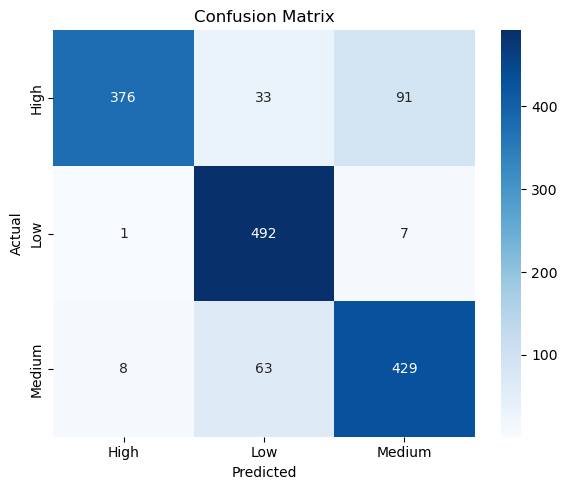

In [1]:
# === Model Training with Augmentation, Class Weights, Evaluation ===

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- Base Model Setup ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Dataset Paths ---
train_dir = r'C:\Hope\AI Course Tamil\8.Deep Learning\Traffic AI\SmartTrafficAI\dataset\train'
val_dir = r'C:\Hope\AI Course Tamil\8.Deep Learning\Traffic AI\SmartTrafficAI\dataset\val'

# --- Image Augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# --- Data Loaders ---
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

# --- Class Weights Calculation ---
y_train = train_gen.classes
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("📊 Class Weights:", class_weights)

# --- Model Training ---
model.fit(train_gen, validation_data=val_gen, epochs=10, class_weight=class_weights)

# --- Save the model ---
model.save(r"C:\Hope\AI Course Tamil\8.Deep Learning\Traffic AI\SmartTrafficAI\model\traffic_congestion_model.h5")

# --- Evaluation Metrics ---
val_gen.reset()
pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [16]:
# === Real-Time Traffic Level Prediction from Video ===

import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Decision logic
def decide_signal_time(congestion_level):
    if congestion_level == 'High':
        return 40
    elif congestion_level == 'Medium':
        return 30
    elif congestion_level == 'Low':
        return 10

# Load trained model
model = load_model(r'C:\Hope\AI Course Tamil\8.Deep Learning\Traffic AI\SmartTrafficAI\model\traffic_congestion_model.h5')
labels = ['High', 'Medium', 'Low']

# Load traffic video
cap = cv2.VideoCapture(r'C:\Hope\AI Course Tamil\8.Deep Learning\Traffic AI\SmartTrafficAI\sample_traffic_video7.mp4')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess image
    img = cv2.resize(frame, (224, 224)) / 255.0
    prediction = model.predict(np.expand_dims(img, axis=0))[0]
    level = labels[np.argmax(prediction)]
    green_time = decide_signal_time(level)

    # Display result
    cv2.putText(frame, f"Congestion: {level} | Green: {green_time}s", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    cv2.imshow("Smart Traffic AI - Video Mode", frame)

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━